# Homework 7: The Exoplanet Kepler-5b

In [1]:
%matplotlib inline
import numpy as np
from matplotlib.pyplot import *
from matplotlib import rc
from IPython.display import display, Markdown, Latex

# Make more readable plots
rc('font',**{'size':14})
rc('xtick',**{'labelsize':16})
rc('ytick',**{'labelsize':16})
rc('axes',**{'labelsize':18,'titlesize':18})

Load in the lightcurve data here and plot

In [2]:
t, I = np.loadtxt("lightcurve_data.txt", unpack=True)

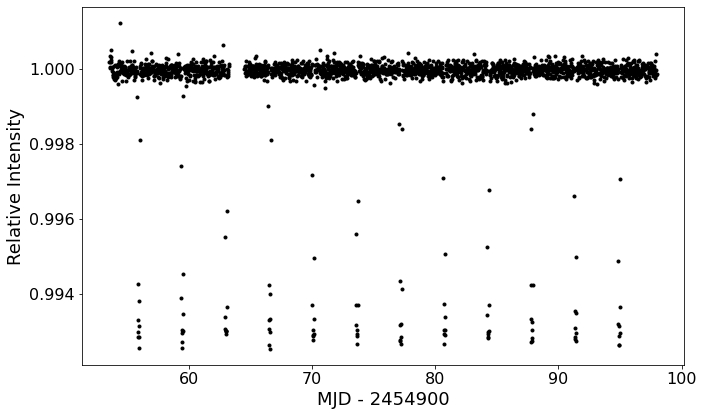

In [3]:
figure(figsize=(10, 6))
ax = subplot(111)
ax.plot(t-2454900, I, 'k.')
ax.set_xlabel('MJD - 2454900')
ax.set_ylabel("Relative Intensity")
tight_layout()
show()

Fold the lightcurve by the period $P = 3.5485$ days, resort the values for later plotting clarity, and plot

In [4]:
t0 = t[0] #store the initial time for later
tprime = (t - t0) % 3.5485
inds = np.argsort(tprime)
tprime = tprime[inds]
I = I[inds]
N = len(t)

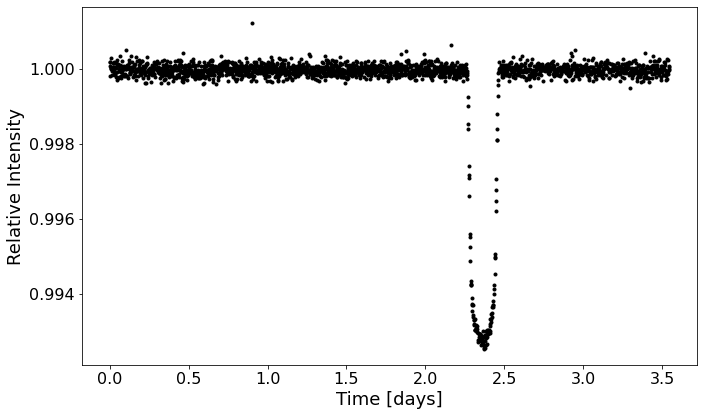

In [5]:
figure(figsize=(10, 6))
ax = subplot(111)
ax.plot(tprime, I, 'k.')
ax.set_xlabel('Time [days]')
ax.set_ylabel("Relative Intensity")
tight_layout()
show()

Let's define a boxcar function for the dip and show an approximate fit. The signal model then has three parameters, the center of the dip $t_{\rm ref}$, the width $\tau$, and the dip intensity $\Delta I$.

In [6]:
def dip(t, tref, tau, dI, baseline=1.0):
    """
    Inverse boxcar function
    
    Parameters
    ----------
    t : np.ndarray
        List of times to evaluate
    tref : float
        Center of the dip
    tau : float
        Width of the dip
    dI : float
        Intensity of the dip, relative to the maximum
    baseline (optional) : float
        Value of the no-signal model, by default = 1
        
    Returns
    -------
    signal : np.ndarray
        Signal model for the transit lightcurve
    """
    signal = np.zeros(len(t)) + baseline
    inds = np.where((tref-tau/2.0<=t)&(t<=tref+tau/2.0))
    signal[inds] -= dI
    return signal

Plot the model given some fiducial parameters

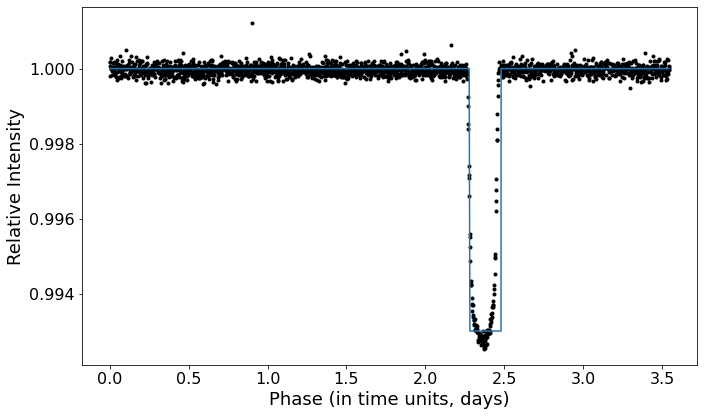

In [7]:
figure(figsize=(10, 6))
ax = subplot(111)
ax.plot(tprime, I, 'k.')
ax.plot(tprime, dip(tprime, 2.38, 0.2, 0.007), 'C0')
ax.set_xlabel('Phase (in time units, days)')
ax.set_ylabel("Relative Intensity")
tight_layout()
show()

By eye, we can see that $t_{\rm ref} = 2.38$ days, $\tau = 0.2$ days, and $\Delta I = 0.007$ provides a reasonable fit to the data

In [8]:
def log_likelihood(t, I, tref, tau, dI, sigma=1):
    """
    Log-likelihood function
    
    Parameters
    ----------
    t : np.ndarray
        List of times to evaluate
    I : np.ndarray
        List of intensities to evaluate
    tref : float
        Center of the dip
    tau : float
        Width of the dip
    dI : float
        Intensity of the dip, relative to the maximum
    sigma (optional) : float
        Single-valued uncertainties in the measurements
        
    Returns
    -------
    lnL : np.ndarray
        Log-likelihood value
    """
    N = len(t)
    lnL = -0.5 * N * np.log(2*np.pi*sigma**2) - 0.5*np.sum(np.power((I - dip(t, tref, tau, dI))/sigma, 2.0))
    return lnL

We can see that shifting the values from the reasonable initial guesses result in decreased likelihoods. 

In [9]:
print(log_likelihood(tprime, I, 2.38, 0.2, 0.007))
print(log_likelihood(tprime, I, 2.38, 0.4, 0.007))
print(log_likelihood(tprime, I, 2.38, 0.2, 0.01))
print(log_likelihood(tprime, I, 2.43, 0.2, 0.007))

-1931.609256374374
-1931.611994515374
-1931.6102463353739
-1931.610551696374


Solving for sigma is a better approach if we can about the actual values. We can do this in the MCMC, but for simplicity, I will simply take the root mean square of the baseline.

In [10]:
sigma = np.std(I[N//2:])
print(log_likelihood(tprime, I, 2.38, 0.2, 0.007, sigma=sigma))
print(log_likelihood(tprime, I, 2.38, 0.4, 0.007, sigma=sigma))
print(log_likelihood(tprime, I, 2.38, 0.2, 0.01, sigma=sigma))
print(log_likelihood(tprime, I, 2.43, 0.2, 0.007, sigma=sigma))

11066.401226898817
10344.335992632756
10805.342201312018
10724.816559279443


-----

Now let's run through the Metropolis-Hastings algorithm. We will first define a set of initial values, though with the "current" label. From there, we will produce the 


The jumps that I will choose will be drawn from normal distributions. However, since I know the rough

In [11]:
niter = 20000
np.random.seed(42)

# Initial values
current_params = np.array([2.38, 0.2, 0.007])
# We will store all of the chains here
chains = np.zeros((niter, 3))

for i in range(niter):
    # Propose a new jump in parameter space
    # Given the precisions involved, choose from steps with distributions of different widths
    delta = np.array([np.random.normal(0, 0.001), np.random.normal(0, 0.001), np.random.normal(0, 0.0001)])
    proposed_params = current_params + delta
    current_lnL = log_likelihood(tprime, I, current_params[0], current_params[1], current_params[2], sigma=sigma)
    proposed_lnL = log_likelihood(tprime, I, proposed_params[0], proposed_params[1], proposed_params[2], sigma=sigma)
    # Metropolis ratio, converted towards probabilities
    ln_r = proposed_lnL - current_lnL
    r = np.exp(ln_r)
    if r >= 1:
        current_params = proposed_params
    else:
        U = np.random.uniform()
        if U <= r:
            current_params = proposed_params
    chains[i, :] = current_params

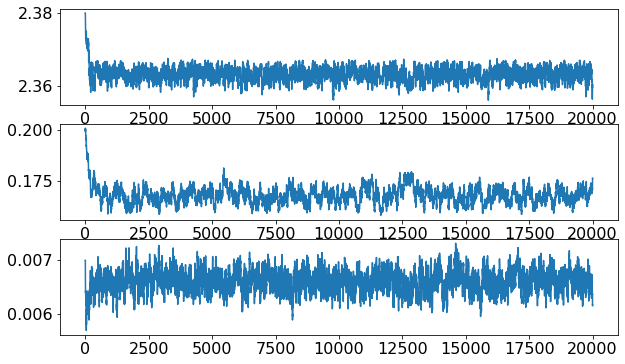

In [12]:
figure(figsize=(10, 6))
subplot(311)
plot(chains[:, 0])
subplot(312)
plot(chains[:, 1])
subplot(313)
plot(chains[:, 2])

Look at the distributions of each of the parameters

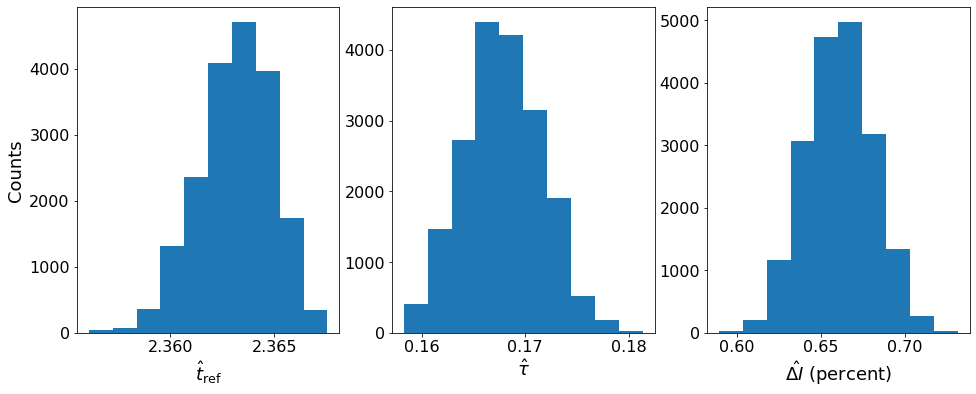

In [13]:
burn = 1000

figure(figsize=(16, 6))
subplot(131)
hist(chains[burn:, 0])
xlabel(r"$\hat{t}_{\rm ref}$")
ylabel("Counts")
subplot(132)
hist(chains[burn:, 1])
xlabel(r"$\hat{\tau}$")
subplot(133)
hist(100*chains[burn:, 2])
xlabel(r"$\hat{\Delta I}~(\rm{percent})$")
show()

Using `np.percentile`, we can calculate the median (in this case rather than using the maximum likelihood itself, just for simplicity) and the inner 68.3% confidence interval.

In [14]:
tref_hat = np.percentile(chains[burn:, 0], [50-34.15, 50, 50+34.15])
tau_hat = np.percentile(chains[burn:, 1], [50-34.15, 50, 50+34.15])
dI_hat = np.percentile(chains[burn:, 2], [50-34.15, 50, 50+34.15])

In [15]:
display(Latex(r"$\hat{t}_{\rm ref} = %0.4f_{-%0.4f}^{+%0.4f}~\text{days}$"%(tref_hat[1]+t0, 
                                                                            tref_hat[1] - tref_hat[0], 
                                                                            tref_hat[2] - tref_hat[1])))
display(Latex(r"$\hat{\tau} = %0.4f_{-%0.4f}^{+%0.4f}~\text{days}$"%(tau_hat[1], 
                                                                     tau_hat[1] - tau_hat[0], 
                                                                     tau_hat[2] - tau_hat[1])))
display(Latex(r"$\hat{\Delta I} = %0.3f_{-%0.3f}^{+%0.3f}$%%"%(100*dI_hat[1], 
                                                               100*(dI_hat[1] - dI_hat[0]), 
                                                               100*(dI_hat[2] - dI_hat[1]))))

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

The errors are fairly symmetric, which makes sense given the plots above.

-----

Make a plot with the best-fit parameters and the residuals

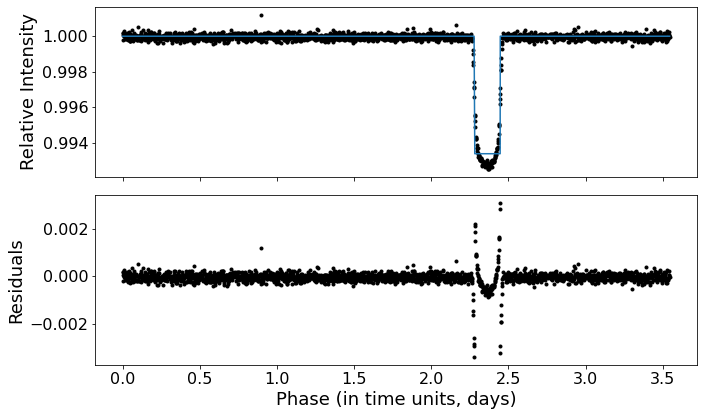

In [16]:
figure(figsize=(10, 6))
ax = subplot(211)
ax.plot(tprime, I, 'k.')
ax.plot(tprime, dip(tprime, tref_hat[1], tau_hat[1], dI_hat[1]), 'C0')
ax.set_xticklabels([])
ax.set_ylabel("Relative Intensity")
ax = subplot(212)
ax.plot(tprime, I-dip(tprime, tref_hat[1], tau_hat[1], dI_hat[1]), 'k.')
ax.set_xlabel('Phase (in time units, days)')
ax.set_ylabel("Residuals")
tight_layout()
show()

As we can see, the boxcar model is not ideal. So even though the true minimum of the lightcurve should clearly be lower, this is the best fit according the the minimization of the residuals.

-----

What if we start with worse initial guesses?

In [17]:
niter = 20000
np.random.seed(42)

# Initial values
current_params = np.array([2.48, 0.1, 0.02])
# We will store all of the chains here
chains = np.zeros((niter, 3))

for i in range(niter):
    # Propose a new jump in parameter space
    # Given the precisions involved, choose from steps with distributions of different widths
    delta = np.array([np.random.normal(0, 0.001), np.random.normal(0, 0.001), np.random.normal(0, 0.0001)])
    proposed_params = current_params + delta
    current_lnL = log_likelihood(tprime, I, current_params[0], current_params[1], current_params[2], sigma=sigma)
    proposed_lnL = log_likelihood(tprime, I, proposed_params[0], proposed_params[1], proposed_params[2], sigma=sigma)
    # Metropolis ratio, converted towards probabilities
    ln_r = proposed_lnL - current_lnL
    r = np.exp(ln_r)
    if r >= 1:
        current_params = proposed_params
    else:
        U = np.random.uniform()
        if U <= r:
            current_params = proposed_params
    chains[i, :] = current_params

Let's plot the chains to see what's happening

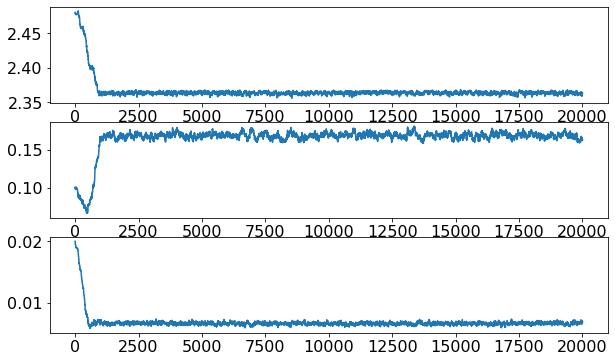

In [18]:
figure(figsize=(10, 6))
subplot(311)
plot(chains[:, 0])
subplot(312)
plot(chains[:, 1])
subplot(313)
plot(chains[:, 2])

We can see that with our jump size, it takes a while to hone in on the maximum likelihood. If we chop off more of the first set of parameters without rerunning for longer, we still see that we arrive at similar parameter estimates.

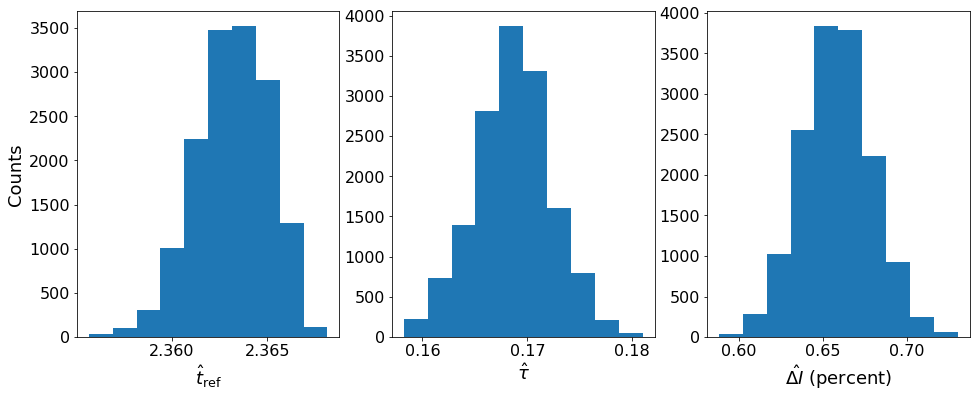

In [19]:
burn = 5000

figure(figsize=(16, 6))
subplot(131)
hist(chains[burn:, 0])
xlabel(r"$\hat{t}_{\rm ref}$")
ylabel("Counts")
subplot(132)
hist(chains[burn:, 1])
xlabel(r"$\hat{\tau}$")
subplot(133)
hist(100*chains[burn:, 2])
xlabel(r"$\hat{\Delta I}~(\rm{percent})$")
show()

In [20]:
tref_hat = np.percentile(chains[burn:, 0], [50-34.15, 50, 50+34.15])
tau_hat = np.percentile(chains[burn:, 1], [50-34.15, 50, 50+34.15])
dI_hat = np.percentile(chains[burn:, 2], [50-34.15, 50, 50+34.15])

In [21]:
display(Latex(r"$\hat{t}_{\rm ref} = %0.4f_{-%0.4f}^{+%0.4f}~\text{days}$"%(tref_hat[1]+t0, 
                                                                            tref_hat[1] - tref_hat[0], 
                                                                            tref_hat[2] - tref_hat[1])))
display(Latex(r"$\hat{\tau} = %0.4f_{-%0.4f}^{+%0.4f}~\text{days}$"%(tau_hat[1], 
                                                                     tau_hat[1] - tau_hat[0], 
                                                                     tau_hat[2] - tau_hat[1])))
display(Latex(r"$\hat{\Delta I} = %0.3f_{-%0.3f}^{+%0.3f}$%%"%(100*dI_hat[1], 
                                                               100*(dI_hat[1] - dI_hat[0]), 
                                                               100*(dI_hat[2] - dI_hat[1]))))

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

Which is extremely consistent with what we had earlier.

-----

Given the stellar radius of $1.79R_\odot$, the radius of the planet is:

In [22]:
R_p_med = 1.79*np.sqrt(dI_hat[1])
# propagate uncertainties
# for f(x) = 1.79*sqrt(x), then df = 1.79*dx/(2 x^1/2)
R_p_err = 1.79*((dI_hat[2]-dI_hat[0])/2.0) / (2*dI_hat[1])

In [23]:
display(Latex(r"$R_p = %0.3f \pm %0.3f R_\odot$"%(R_p_med, R_p_err)))

<IPython.core.display.Latex object>

Or, in Jupiter masses

In [24]:
display(Latex(r"$R_p = %0.2f \pm %0.2f R_J$"%(R_p_med/0.10049, R_p_err/0.10049)))

<IPython.core.display.Latex object>

Thus, with a Jupiter-radius planet circling rapidly around a star, you might guess that Kepler-5b is a Hot Jupiter even without the radial velocity data. Note that the uncertainty is the stochastic measurement error and *not* any systematic due to the improper model. The radius is likely different when a proper model is used.